In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
PATH_DATA = "data"
df_raw = pd.read_csv(
    f"{PATH_DATA}/lote1.csv",
    sep=";",
    quotechar='"',
    encoding="utf-8",
    engine="python",
    on_bad_lines="skip"
)


Qual é a ideia:
- a partir de dados facilmente extraíveis em exames / dados clínicos, estimar a probabilidade da pessoa estar doente de covid por exemplo
- isso presume que
- - é necessário retirar campos que

Perguntas:
- retirar pessoas sem cpf (dificil demais de lidar)
- a Covid atinge mais qual raça?
- ser profissional da segurança ou de saúde impacta em algo?
- sexo impacta em algo?
- é possível se ter uma ideia de municipios afetados? fazendo algo com geolocalização por exemplo (centro, periferia, zona rural)
- estrangeiros são mais suscetíveis?
- as condições do paciente (outras coisas que ele tem) influencia nos sintomas ou algo do tipo?
- qual é a distribuição por estado? e de forma temporal?
- importante considerar a evolucao do caso
- classificação final tem coisas importantes: considerar o descartado e o confirmado laboratorial
- faixa de idade influencia na evolucao do caso? (cura, óbito, etc)
- internado e internado em UTI para a classificação final devem estar juntos? faz sentido tentar predizer a internação? Vale a pena retirar junto com tratamento domiciliar ou só deixo?
- vale a pena retirar os que possuem evolucaoCaso == Ignorado?
- é possível mapear sintomas e outrosSintomas com espaço de embeddings para tentar uma classificação de baixo,médio e alto risco? É importante fazer a verificação de texto "Outros" pra juntar com o outrosSintomas.
- CBO mostra as profissões. É possível fazer um embedding com redução de dimensionalidade e clustering pra tentar pegar áreas como "saúde", "educação", "segurança". Os de saúde e de segurança já existem como colunas fixas no dataset, então dá pra usar UMAP supervisionado para reduzir a dimensionalidade do embedding.
- para praticamente todos os casos em que se trabalhar com embedding, precisa utilizar mapeamento com unique pq são dados demais. Dá pra usar alguma classe pra fazer isso.

In [3]:
aaa = ['evolucaoCaso']
print(df_raw[aaa].value_counts()[:30])

print("\n")

aaa = ['classificacaoFinal']
print(df_raw[aaa].value_counts()[:30])
# df_raw[aaa].info()

evolucaoCaso            
Cura                        563340
Ignorado                     70009
Cancelado                    27748
Em tratamento domiciliar      9333
Óbito                         1017
Internado                      370
Internado em UTI                90
Name: count, dtype: int64


classificacaoFinal               
Descartado                           351482
Confirmado Laboratorial              160498
Síndrome Gripal Não Especificada     138989
Confirmado Clínico-Epidemiológico      3741
Confirmado por Critério Clínico        3376
Confirmado Clínico-Imagem               172
Name: count, dtype: int64


In [4]:
df_raw['municipioNotificacao'].value_counts()[:10]

municipioNotificacao
São Paulo                217374
São José do Rio Preto     40854
Barueri                   33887
Campinas                  29875
Catanduva                 26624
Pindamonhangaba           24982
Guarulhos                 21912
Marília                   21709
São José dos Campos       18038
Caraguatatuba             16990
Name: count, dtype: int64

In [5]:
important_columns = [a for a in list((df_raw.columns)) if
                     ('dat' not in a and
                      'codig' not in a and
                      'estad' not in a and
                      'lot' not in a and
                      'ibge' not in a.lower() and
                      'outroBuscaAtivaAssintomatico'!=a and
                      'outroTriagemPopulacaoEspecifica'!=a and
                      'outroLocalRealizacaoTestagem'!=a and
                      'source_id'!=a and
                      'excluido'!=a and
                      'validado'!=a and
                      'origem'!=a and
                      'municipioNotificacao'!=a)]
df = df_raw[important_columns]

## retira pessoas sem sintomas
df = df.dropna(subset='sintomas',axis=0)
print("Len df: ",len(df))
important_columns

Len df:  873387


['sintomas',
 'profissionalSaude',
 'racaCor',
 'outrosSintomas',
 'outrasCondicoes',
 'profissionalSeguranca',
 'cbo',
 'condicoes',
 'sexo',
 'municipio',
 'evolucaoCaso',
 'classificacaoFinal',
 'totalTestesRealizados',
 'idade']

## CBO - Profissões

In [6]:
cbo = df['cbo'].unique()
len(cbo)

499

In [7]:
import re

cbo_codes = []
for item in cbo:
    if isinstance(item, str):
        match = re.match(r'(\d+)\s-', item)
        if match:
            cbo_codes.append(match.group(1))
cbo_unicos = list(set(cbo_codes))
print(len(cbo_unicos))


466


In [8]:
cbo_profissoes_unicas = []
seen_cbo_codes = set()

for item in cbo:
    if isinstance(item, str):
        match = re.match(r'(\d+)\s-\s*(.*)', item)
        if match:
            current_code = match.group(1)
            profession_name = match.group(2)
            if current_code not in seen_cbo_codes:
                cbo_profissoes_unicas.append(profession_name)
                seen_cbo_codes.add(current_code)

print(f"Quantidade de profissões únicas com código: {len(cbo_profissoes_unicas)}")
display(list(sorted(cbo_profissoes_unicas))[:10]) # Exibe as 10 primeiras para visualização

Quantidade de profissões únicas com código: 466


['Administradores',
 'Administradores de tecnologia da informação',
 'Advogados',
 'Afiadores e polidores de metais',
 'Agente Comunitário de Saúde',
 'Agente de Combate a Endemias',
 'Agente de Saúde Pública',
 'Agentes',
 'Agentes  fiscais metrológicos e de qualidade',
 'Agentes da saúde e do meio ambiente']

In [9]:
import re
import numpy as np

# Function to extract the CBO code (numeric part before '-')
def extract_cbo_code(cbo_string):
    if pd.isna(cbo_string):
        return np.nan # Keep NaN values as NaN
    match = re.match(r'(\d+)\s-', str(cbo_string))
    if match:
        return match.group(1)
    return np.nan # If the format doesn't match, treat as NaN

# Apply the function to create a new temporary column with only CBO codes
df['cbo_only_code'] = df['cbo'].apply(extract_cbo_code)

# Perform nominal encoding using pd.factorize
# pd.factorize assigns a unique integer to each unique value.
# By default, NaN values are assigned -1 in the encoded column.
df['cbo_encoded'], _ = pd.factorize(df['cbo_only_code'])

# Display some information about the new column
print("Value counts for cbo_encoded:")
print(df['cbo_encoded'].value_counts(dropna=False))
print("\nFirst 5 rows of cbo, cbo_only_code, and cbo_encoded:")
print(df[['cbo', 'cbo_only_code', 'cbo_encoded']].head())

Value counts for cbo_encoded:
cbo_encoded
-1      839209
 7        5277
 1        4787
 16       2718
 3        1482
         ...  
 445         1
 446         1
 463         1
 464         1
 465         1
Name: count, Length: 467, dtype: int64

First 5 rows of cbo, cbo_only_code, and cbo_encoded:
   cbo cbo_only_code  cbo_encoded
0  NaN           NaN           -1
1  NaN           NaN           -1
2  NaN           NaN           -1
3  NaN           NaN           -1
4  NaN           NaN           -1


## Tratando com sintomas

In [10]:
## Mostrando como o texto 'Outros' aparece
outros_sintomas = df['sintomas'].str.contains('outros', na=False,case=False)
df.loc[outros_sintomas, 'sintomas'].head(10)

9                                                Outros
12                                Outros, Dor de Cabeça
22                                Outros, Dor de Cabeça
24                              Dor de Garganta, Outros
29                                        Tosse, Outros
37                                               Outros
40                       Dor de Garganta, Outros, Tosse
43    Coriza, Distúrbios Olfativos, Distúrbios Gusta...
44                                               Outros
46                         Febre, Tosse, Coriza, Outros
Name: sintomas, dtype: object

Como o texto "Outros" pode aparecer em várias posições, vou fazer um limpador de texto (já foi verificado que o texto é sempre "Outros" e não possui variações como "Outro", "Outra" etc)

In [11]:
texts = df.loc[outros_sintomas, 'sintomas'].head(10).unique().tolist()

def clear_outros(text:str,replace={
    'Outros, ':'',
    ', Outros':'',
    'Outros':'',
}):
    text_aux = text.lower()
    for string,rep in replace.items():
        text_aux = text_aux.replace(string.lower(),rep)
    return text_aux

for text in texts:
    cleaned = clear_outros(text)
    print(f"[{text}] -> [{cleaned}]")

[Outros] -> []
[Outros, Dor de Cabeça] -> [dor de cabeça]
[Dor de Garganta, Outros] -> [dor de garganta]
[Tosse, Outros] -> [tosse]
[Dor de Garganta, Outros, Tosse] -> [dor de garganta, tosse]
[Coriza, Distúrbios Olfativos, Distúrbios Gustativos, Tosse, Dispneia, Outros] -> [coriza, distúrbios olfativos, distúrbios gustativos, tosse, dispneia]
[Febre, Tosse, Coriza, Outros] -> [febre, tosse, coriza]


In [12]:
df['sintomas_clear'] = df['sintomas'].map(clear_outros)
df['sintomas_clear'].head()

0                   assintomático
1                   assintomático
2    coriza, dor de cabeça, tosse
3                   assintomático
4                   assintomático
Name: sintomas_clear, dtype: object

Existem as colunas Sintomas e OutrosSintomas, então vou fazer um merging do texto das duas

In [13]:
df['sintomas_total'] = (df['sintomas_clear'].map(lambda text: text+', ' if len(text)>0 else text)).str.cat(df['outrosSintomas'].str.lower(),na_rep='')
df[['sintomas','outrosSintomas','sintomas_total']][df['outrosSintomas'].notnull()].head()

,sintomas,outrosSintomas,sintomas_total
9,Outros,"VERTIGEM, CALAFRIO, MIALGIA INTESA","vertigem, calafrio, mialgia intesa"
12,"Outros, Dor de Cabeça","NÁUSEA, DOR NAS COSTAS E NAS PERNAS","dor de cabeça, náusea, dor nas costas e nas pe..."
22,"Outros, Dor de Cabeça",SINTOMAS GRIPAIS,"dor de cabeça, sintomas gripais"
24,"Dor de Garganta, Outros",CALAFRIO,"dor de garganta, calafrio"
29,"Tosse, Outros",PERDA DO PALDAR,"tosse, perda do paldar"


Agora que os sintomas estão organizados, separamos por vírgula

In [14]:
unSint2index = {} ## guarda a relação 'sintoma':[index1,index2...] em que ele aparece
for idx,sintomas in df['sintomas_total'].items():
    for sintoma in sintomas.replace("/",",").split(','):
        if len(sintoma.replace(' ',''))==0: ## tira textos vazios
            continue
        sintoma = sintoma[1:] if sintoma[0]==' ' else sintoma
        if sintoma in unSint2index.keys():
            unSint2index[sintoma].append(idx)
        else:
            unSint2index[sintoma] = [idx,]

In [15]:
len(unSint2index)

36035

In [16]:
iter_dict = iter(unSint2index.items())
for i in range(100):
    sintoma,idxs = next(iter_dict)
    print(f"{sintoma:50}| qtd idxs:{len(idxs)}")

assintomático                                     | qtd idxs:210601
coriza                                            | qtd idxs:255309
dor de cabeça                                     | qtd idxs:298996
tosse                                             | qtd idxs:376407
dispneia                                          | qtd idxs:93903
dor de garganta                                   | qtd idxs:273627
febre                                             | qtd idxs:213265
vertigem                                          | qtd idxs:333
calafrio                                          | qtd idxs:2475
mialgia intesa                                    | qtd idxs:1
náusea                                            | qtd idxs:858
dor nas costas e nas pernas                       | qtd idxs:4
distúrbios olfativos                              | qtd idxs:55884
distúrbios gustativos                             | qtd idxs:62257
sintomas gripais                                  | qtd idxs:923
perd

In [17]:
all_sintomas = list(unSint2index.keys())

### Embeddings + UMAP

Agora que temos o texto bonitinho de todo mundo, vamos fazer um embedding usando o sentence transformer

In [18]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import os
import dill as dl

## otimização pra não ficar recomputando 
if os.path.exists("embeddings_sintomas.pkl"):
    ## recupera do arquivo
    print("Embeddings recuperadas do arquivo")
    with open('embeddings_sintomas.pkl','rb') as f:
        embeddings = dl.load(f)
else:
    ## faz as embeddings e salva
    print("Fazendo embeddings e salvando")
    embeddings = model.encode(all_sintomas)
    with open('embeddings_sintomas.pkl','wb') as f:
        dl.dump(embeddings,f)

Embeddings recuperadas do arquivo


In [20]:
import umap

min_dist = 0.1
n_neighbors=200
n_components=10

## faz o mesmo processo de recuperar do umap também
if os.path.exists("mapper_2d.pkl"):
    ## recupera do arquivo
    print("UMAP mapper 2d recuperado do arquivo")
    with open('mapper_2d.pkl','rb') as f:
        mapper2d = dl.load(f)
else:
    ## faz as embeddings e salva
    print("Fazendo umap 2d e salvando")
    mapper2d = umap.UMAP(metric='cosine',
                    min_dist=min_dist,
                    n_neighbors=n_neighbors,
                    n_components=2,
                    random_state=42,
                    low_memory=True).fit(embeddings)
    
    with open('mapper_2d.pkl','wb') as f:
            dl.dump(mapper2d,f)



## faz o mesmo processo de recuperar do umap também
if os.path.exists("mapper.pkl"):
    ## recupera do arquivo
    print("UMAP mapper recuperado do arquivo")
    with open('mapper.pkl','rb') as f:
        mapper = dl.load(f)
else:
    ## faz as embeddings e salva
    print("Fazendo umap e salvando")
    mapper = umap.UMAP(metric='cosine',
                    min_dist=min_dist,
                    n_neighbors=n_neighbors,
                    n_components=n_components,
                    random_state=42,
                    low_memory=True).fit(embeddings)
    
    with open('mapper.pkl','wb') as f:
            dl.dump(mapper,f)

UMAP mapper 2d recuperado do arquivo
UMAP mapper recuperado do arquivo


In [21]:
data2d = mapper2d.transform(embeddings)
data = mapper.transform(embeddings)

### Fazendo clustering

/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


49
Quantidade de clusters:  49
[-1 | 1260]: ['falta de a r', 'histórico de pneumonia', 'dor na cabeça e vomitos', 'falta de ar e fadiga', 'dor abdominal vomito', 'nao especificado na ficha de atendimento', 'dor cervica', 'dor no olho ansia e vertigem', 'dor nas costas e pontada do rins', 'urina com odor e concentrada']
[ 0 | 487]: ['esado gripal', 'sintomas gripais (4 dias)', 'síndrome gripal ', 'tontura e gripe', 'obs?: paciente realizou testagem para dengue na data de 20', 'sintomar gripais em geral', 'fadiga . refere ser alergica a vacina da gripe', 'sintimas gripais', 'sintomas de gripre', 'dor de barriga e gripe']
[ 1 | 119]: ['espirros dor nas costas e dor no olho fraqueza', 'dor no fundo do olho e dor nas costas', 'dor nas costas ardencias nos olhos', 'dor nas costas e atras dos olhos', 'dor nas costas e ardencia em olhos', 'dor nas costas e olhos', 'visão turva e dor nas costas', 'dor no fundo do olho e dor nas costas', 'vermelhidão dos olhos e cansaço', 'nor ocular e fadiga']


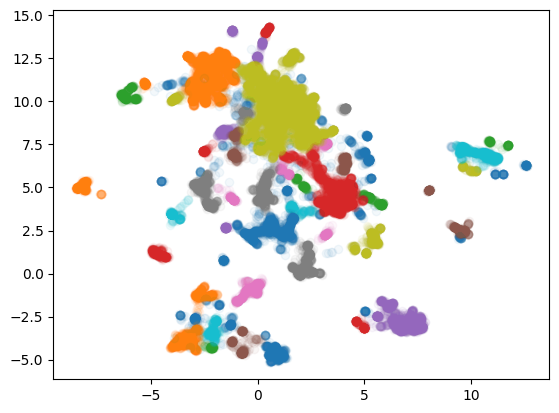

In [22]:
import matplotlib.pyplot as plt
import hdbscan
import numpy as np
from random import choices

clusterer2d = hdbscan.HDBSCAN(min_cluster_size=100,
                              cluster_selection_epsilon=0.1,
                              min_samples=1)
clusterer2d.fit(data2d)

unique_labels2d = np.unique(clusterer2d.labels_)

for label in unique_labels2d:
    idx = clusterer2d.labels_==label
    plt.scatter(data2d[idx,0],data2d[idx,1],alpha=0.05)

print(len(unique_labels2d))
print("Quantidade de clusters: ",len(unique_labels2d))
for label in unique_labels2d[:30]:
    idx = np.where(clusterer2d.labels_==label)[0]
    sintomas_cluster = [all_sintomas[i] for i in idx]
    print(f"[{label:2} | {len(sintomas_cluster)}]: {choices(sintomas_cluster,k=10)}")
    
plt.show()

In [23]:
import matplotlib.pyplot as plt
import hdbscan
import numpy as np

clusterer = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=0.1,min_samples=1)
clusterer.fit(data)
unique_labels = np.unique(clusterer.labels_)

print("Quantidade de clusters: ",len(unique_labels))
for label in unique_labels[:30]:
    # if label == -1:
    #     continue
    idx = np.where(clusterer.labels_==label)[0]
    sintomas_cluster = [all_sintomas[i] for i in idx]
    print(f"[{label:2} | {len(sintomas_cluster)}]: {sintomas_cluster[:10]}")

/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Quantidade de clusters:  73
[-1 | 7103]: ['assintomático', 'coriza', 'tosse', 'dispneia', 'vertigem', 'calafrio', 'distúrbios olfativos', 'distúrbios gustativos', 'calafrios', 'produção de escarro']
[ 0 | 1583]: ['dor nos olhos', 'tontura e dor nos olhos', 'ardencia nos olhos', 'dor nos olhos - cansaço', 'ardencia no olho.', 'ardencia olhos', 'dor fundo do olho', 'irritação nos olhos', 'espirros e irritação ocular', 'dor no fundo dos olhos']
[ 1 | 502]: ['dor de ouvido', 'fadiga. dor no corpo. dor nos olhos no ouvido', 'cabeça e ouvido', 'dor no ouvido e mialgia', 'dor ouvido', 'dor de ouvido e dor nos olhos', 'dor em fronte e dor em ouvido.', 'sensação de obstrução no ouvido', 'dor no ouvido', 'dor nas costas e dor de ouvido']
[ 2 | 2018]: ['espirros irritacao nariz', 'consgestão nasal', 'sangramento nasal', 'obstrução nasal', 'mialgia e obstrução nasal', 'congestao nasal', 'congestão nasal', 'vertigens e 1 episodio de sangramento nasal', 'congestao nasal omesmo tomou a 1 dose 08\\\\0

Beleza, agora que já passou toda a etapa de embedding, vamos fazer um processamento nesses textos pra limpar eles. Tirar acentos, stopwords,
voltar a palavra pra raiz, e essas parada aí.

In [24]:
!python -m spacy download pt_core_news_sm ## downlodeia o modelo do spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 11.2 MB/s  0:00:01 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [25]:
import spacy
nlp = spacy.load("pt_core_news_sm")
doc = nlp("Eu sou uma batata, você é uma batata, nós somos três batatas")
for token in doc:
    print(token.text, "->", token.lemma_)


Eu -> eu
sou -> ser
uma -> um
batata -> batata
, -> ,
você -> você
é -> ser
uma -> um
batata -> batata
, -> ,
nós -> nós
somos -> ser
três -> três
batatas -> batata


In [26]:
import nltk
import string
import unicodedata

nltk.download('stopwords')
first_load = True
LANGUAGE = 'portuguese'
STOPWORDS = nltk.corpus.stopwords.words(LANGUAGE)

def download_nltk():
    global first_load
    if first_load:
        nltk.download('stopwords')
        first_load = False

def remove_accents(text: str) -> str:
    download_nltk()
    nfkd_form = unicodedata.normalize('NFKD', text)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_stopword(text: str) -> str:
    return ' '.join([w for w in text.split(' ') if w not in STOPWORDS])

def clear_text(
    text: str,
    apply_lower: bool = True,
    apply_rmaccents: bool = True,
    apply_rmstopwd: bool = False,
    apply_pontuaction: bool = False,
    apply_lemmatization: bool = False,
) -> str:
    if apply_lower:
        cleaned_text = text.lower()
    else:
        cleaned_text = text

    if apply_lemmatization:
        with nlp.disable_pipes("parser", "ner"):
            cleaned_text = ' '.join([token.lemma_ for token in nlp(cleaned_text)])
    if apply_rmstopwd:
        cleaned_text = remove_stopword(cleaned_text)
    if apply_rmaccents:
        cleaned_text = remove_accents(cleaned_text)
    if apply_pontuaction:
        translator = str.maketrans('', '', string.punctuation)
        cleaned_text = cleaned_text.translate(translator)

    cleaned_text = cleaned_text.replace('  ',' ')
    return cleaned_text

clear_text("Os estudantes, infelizmente, tinham uma prova de cálculo",apply_rmstopwd=True,apply_pontuaction=True,apply_lemmatization=True)

[nltk_data] Downloading package stopwords to /home/miguel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/miguel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'estudante infelizmente ter prova calculo'

In [27]:
import re
import random
from sklearn.feature_extraction.text import CountVectorizer

def get_topics(corpus: list[str], labels:list[int],topk:int=5):
    unique_indexes = np.unique(corpus,return_index=True)[1]

    corpus = corpus[unique_indexes] ## considera o texto já limpo
    labels = labels[unique_indexes]

    unique_labels = np.unique(labels)

    max_features = len(unique_labels)*3 ## considerando um max_features igual a 3x a quantidade de clusters
    print("Max features: ",max_features)

    ## o custom tokenizer serve pra deixar lower, quebrar por espaços e retirar palavras com treatment, que aparece escrito errado na base muitas vezes
    def custom_tokenizer(text):
        # Extrai tokens de letras
        tokens = re.findall(r'\b[a-zA-Z]+\b', text.lower())
        # Remove qualquer palavra que termine com "treatment"
        tokens = [t.replace('treatment','') for t in tokens]
        return tokens

    ## achando contagens com o countvectorizer
    vectorizer = CountVectorizer(stop_words='english',
                                tokenizer=custom_tokenizer,
                                lowercase=False,
                                ngram_range=(1,1),
                                max_features=max_features)
    X_counts = vectorizer.fit_transform(corpus)
    terms = vectorizer.get_feature_names_out()

    ## achando a frequencia de cada termo para cada cluster
    n_terms = len(terms)
    tf_per_class = np.zeros((len(unique_labels), n_terms), dtype=float)
    class_totals = np.zeros(len(unique_labels), dtype=float)

    for i, c in enumerate(unique_labels):
        mask = (labels == c)  ## máscara para os dados que forem do cluster c
        class_sum = X_counts[mask].sum(axis=0)     # X é (dados x termos) então soma todos os dados com a máscara, ficando (,termos)
        class_sum = np.asarray(class_sum).ravel()
        tf_per_class[i, :] = class_sum
        class_totals[i] = class_sum.sum()          # total de tokens na classe

    ## frequencia global dos termos (n_terms,)
    f_x = tf_per_class.sum(axis=0)

    ## media de palavras por classe
    A = class_totals.mean()

    ## normalização na matrix tf
    tf_norm = np.zeros_like(tf_per_class)
    for i in range(len(unique_labels)):
        denom = class_totals[i] if class_totals[i] > 0 else 1.0
        tf_norm[i, :] = tf_per_class[i, :] / denom

    ## calculando c-TF-IDF
    eps = 1e-9
    idf_like = np.log1p(A / (f_x + eps))  # shape (n_terms,)
    c_tfidf = tf_norm * idf_like[np.newaxis, :]  # shape (n_classes, n_terms)

    ## Calculando os topk termos de cada um
    label2topterms = {}
    used_terms = set()
    for i,c in enumerate(unique_labels):
        top_idxs = np.argsort(c_tfidf[i])[::-1][:topk]
        top_terms = [(terms[j], c_tfidf[i, j]) for j in top_idxs]
        used_terms.update(set([term for term, _ in top_terms]))
        label2topterms[c] = top_terms
    used_terms = list(used_terms)
    return used_terms,label2topterms

In [28]:
all_sintomas_clear = np.array([clear_text(sintoma,apply_rmstopwd=True,apply_pontuaction=True,apply_lemmatization=True) for sintoma in all_sintomas])

In [29]:
## mostrando os clusters
labels = clusterer.labels_
corpus = all_sintomas_clear
corpus_original = np.array(all_sintomas)
terms, label2topterms = get_topics(corpus,labels)

# min_threshold = 0.3
print("Qtd clusters: ",len(unique_labels))
for i, c in enumerate(unique_labels[:30]):
    if c==-1:
        continue
    top_terms = label2topterms[c]
    mean_score = np.mean([score for _, score in top_terms])
    top_terms = [(term,score) for term,score in top_terms if score>0.05]

    title = f"\nClasse {c}: topkmean score: {mean_score:.2f} "
    print(title,'-'*(60-len(title)))
    for term, score in top_terms:
        print(f"  {term:<25} {score:.4f}")

    sampled_dfuses_idxs = random.choices(np.where(labels==c)[0],k=5)
    sampled_dfuses = corpus_original[sampled_dfuses_idxs]
    for doc in sampled_dfuses:
        print(f"        {doc.lstrip()}")
    #87384
    print("\n\n\n\n")

Max features:  219


/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Qtd clusters:  73

Classe 0: topkmean score: 0.08  ----------------------------
  olho                      0.1666
  ocular                    0.0996
        dr ocular
        dor nos olhos e dor na costas
        inapetencia e irritacao ocular
        congestão nasal  e dor nos olhos
        calafriosdor nos olhos






Classe 1: topkmean score: 0.12  ----------------------------
  ouvido                    0.2861
  ouvir                     0.2187
        congestão nasal e dor de ouvido
        cefaleia dor de ouvido
        dor nas costas e ouvido
        diarreia dor de cabeça dor de ouvido
        incomodo no ouvido






Classe 2: topkmean score: 0.08  ----------------------------
  nasal                     0.1228
  congestao                 0.0952
  nariz                     0.0750
  obstrucao                 0.0622
        obstrução nasal e espirros
        cansaço congestão nasal rouquidão
        dor em face e retrorbital. congestão nasal
        cogestionamento nasal e mial

### Lidando com casos de confirmação da doença e de óbito

In [30]:
df['evolucaoCaso'].value_counts() ## tem muitos poucos valores com óbito

evolucaoCaso
Cura                        563282
Ignorado                     69919
Cancelado                    27701
Em tratamento domiciliar      9330
Óbito                         1017
Internado                      370
Internado em UTI                90
Name: count, dtype: int64

In [31]:
df['classificacaoFinal'].value_counts()

classificacaoFinal
Descartado                           351425
Confirmado Laboratorial              160411
Síndrome Gripal Não Especificada     138975
Confirmado Clínico-Epidemiológico      3740
Confirmado por Critério Clínico        3376
Confirmado Clínico-Imagem               172
Name: count, dtype: int64

In [32]:
# Casos confirmados
confirmed_classifications = [
    'Confirmado Laboratorial',
    'Confirmado Clínico-Epidemiológico',
    'Confirmado por Critério Clínico',
    'Confirmado Clínico-Imagem'
]


df['confirmed_case'] = np.where(df['classificacaoFinal'].isin(confirmed_classifications), 1, 0)

# Casos com óbito
df['death_case'] = np.where(df['evolucaoCaso'] == 'Óbito', 1, 0)

df[['sintomas_total','confirmed_case','death_case']].head()

,sintomas_total,confirmed_case,death_case
0,"assintomático,",0,0
1,"assintomático,",1,0
2,"coriza, dor de cabeça, tosse,",0,0
3,"assintomático,",0,0
4,"assintomático,",0,0


In [33]:
print(f"Proporção de confirmados: {100*sum(df['confirmed_case'])/len(df):.2f}%")
print(f"Proporção de mortes: {100*sum(df['death_case'])/len(df):.2f}%")

Proporção de confirmados: 19.20%
Proporção de mortes: 0.12%


In [34]:
label2death = {}   ## label : (count,total)
label2confirmed = {} ## label : (count,total)
for label in unique_labels:
    if label==-1:
        continue
    sintomas_idx = np.where(clusterer.labels_ == label)[0] ## index dos sintomas
    sintomas_subset = np.unique([all_sintomas[i] for i in sintomas_idx])
    
    ## subset unificado dos vários sintomas
    subset_index = set()
    for sintoma in sintomas_subset:
        subset_index.update(unSint2index[sintoma])
    
    subset = df.loc[list(subset_index)]
    label2death[label] = (int(subset['death_case'].sum()),len(subset))
    label2confirmed[label] = (int(subset['confirmed_case'].sum()),len(subset))

In [35]:
print("death case")
for i,label in enumerate(unique_labels):
    if label==-1:
        continue
    terms = label2topterms[label][0][0]
    print(label,terms,label2death[label])
    if i>5:
        break
    
print("\n\nconfirm case")
for i,label in enumerate(unique_labels):
    if label==-1:
        continue
    terms = label2topterms[label][0][0]
    print(label,terms,label2confirmed[label])
    if i>5:
        break

death case
0 olho (6, 6175)
1 ouvido (1, 2234)
2 nasal (5, 18834)
3 apetite (6, 2254)
4 anosmio (0, 1811)
5 ardenciar (2, 185)


confirm case
0 olho (1751, 6175)
1 ouvido (319, 2234)
2 nasal (3366, 18834)
3 apetite (663, 2254)
4 anosmio (731, 1811)
5 ardenciar (42, 185)


/tmp/ipykernel_4862/2218293899.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


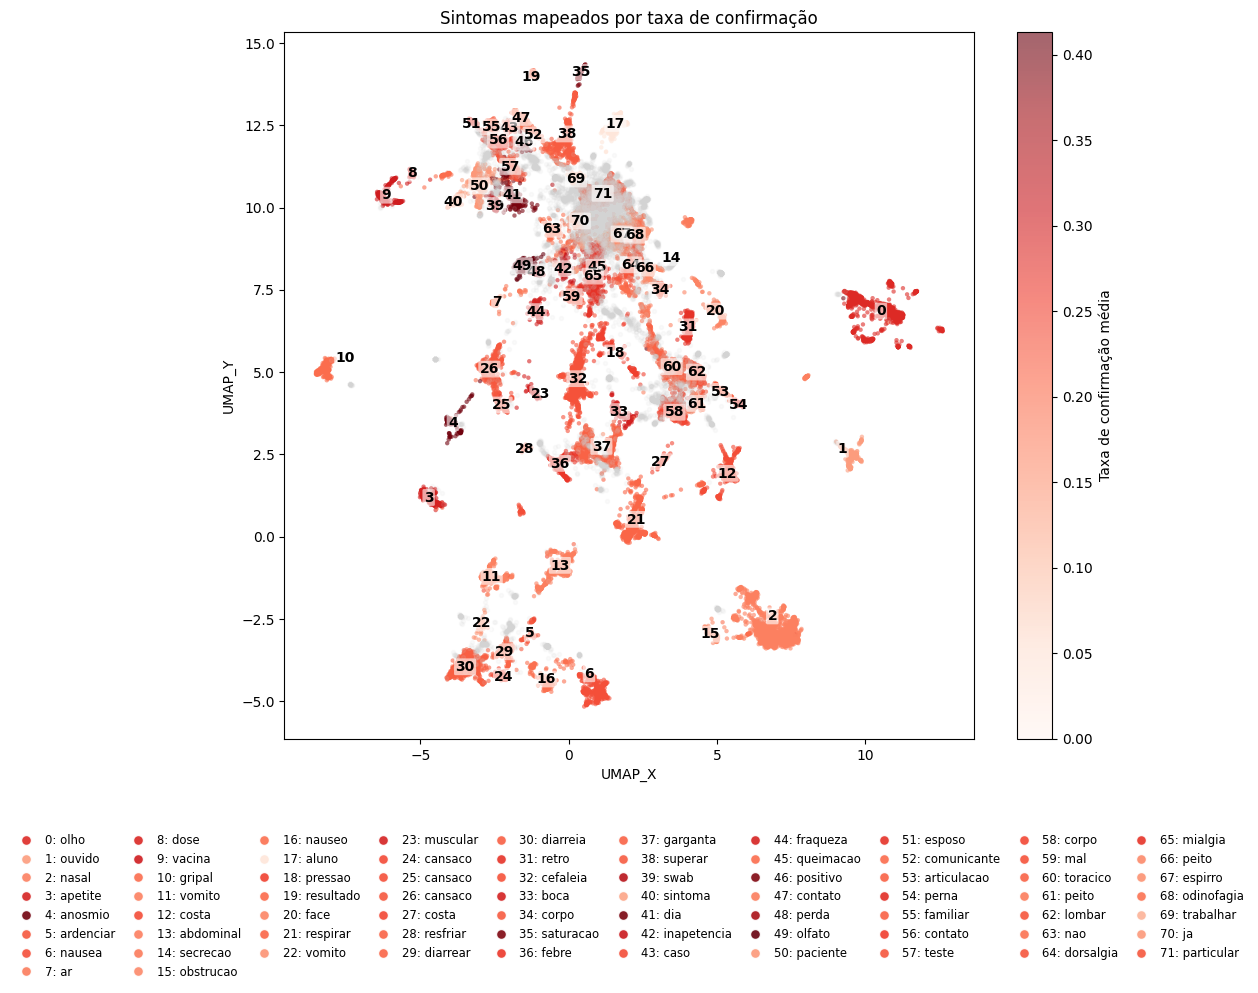

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import Normalize

plot_df = pd.DataFrame(data2d, columns=['UMAP_X', 'UMAP_Y'])
plot_df['cluster_label'] = clusterer.labels_


cluster_confirmation_map = {label:(label2confirmed[label][0]/label2confirmed[label][1]) for label in unique_labels if label!=-1}
plot_df['confirmation_rate'] = plot_df['cluster_label'].map(cluster_confirmation_map).fillna(0.0)

fig, ax = plt.subplots(figsize=(12, 10))
vmin = plot_df['confirmation_rate'].min()
vmax = plot_df['confirmation_rate'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('Reds')

mask = plot_df['cluster_label'] != -1
sc = ax.scatter(
    plot_df.loc[mask, 'UMAP_X'],
    plot_df.loc[mask, 'UMAP_Y'],
    c=plot_df.loc[mask, 'confirmation_rate'],
    cmap=cmap,
    norm=norm,
    s=10,
    alpha=0.6,
    linewidths=0,
)

# Se quiser mostrar ruído (-1) em cinza:
if (plot_df['cluster_label'] == -1).any():
    noise_mask = plot_df['cluster_label'] == -1
    ax.scatter(
        plot_df.loc[noise_mask, 'UMAP_X'],
        plot_df.loc[noise_mask, 'UMAP_Y'],
        color='lightgray',
        s=8,
        alpha=0.1,
        label='-1 (noise)'
    )

# Barra de cores (continua como no código 2)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Taxa de confirmação média')

# --- calcula centros por cluster para numerar ---
centers = (
    plot_df[plot_df['cluster_label'] != -1]
    .groupby('cluster_label')[['UMAP_X', 'UMAP_Y']]
    .mean()
)

# Para a legenda organizada: criamos uma entrada por cluster usando a cor
legend_handles = []
legend_labels = []

unique_labels = centers.index.to_numpy()  # labels distintos (sem -1)

for lab in unique_labels:
    # cor representativa do cluster = cor do colormap aplicada à taxa média (se existir)
    rate = float(cluster_confirmation_map.get(lab, 0.0))
    color = cmap(norm(rate))

    # top term (tenta obter como no código 1)
    try:
        top_term = label2topterms[lab][0][0]
    except Exception:
        top_term = ""

    label_text = f"{lab}: {top_term}"
    # cria handle para a legenda (pequeno marcador circular)
    handle = Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                    markersize=6, alpha=0.9)
    legend_handles.append(handle)
    legend_labels.append(label_text)

    # coloca o número do cluster no centro (texto)
    cx, cy = centers.loc[lab, ['UMAP_X', 'UMAP_Y']]
    ax.text(
        cx, cy, str(lab),
        fontsize=10,
        fontweight="bold",
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.6)
    )

# --- legenda embaixo, centralizada, com colunas como no código 1 ---
ncol = 10  # ajuste conforme número de clusters / estética
ax.legend(
    legend_handles,
    legend_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=ncol,
    fontsize="small",
    frameon=False,
    markerscale=1.2,
    handletextpad=0.6,
    columnspacing=1.0
)

ax.set_title('Sintomas mapeados por taxa de confirmação')
ax.set_xlabel('UMAP_X')
ax.set_ylabel('UMAP_Y')

# espaço para a legenda de baixo
fig.subplots_adjust(bottom=0.20)
plt.tight_layout()
plt.show()


In [37]:
## Clusters com maiores proporções de confirmações 
for i,(label,confirmation) in enumerate(sorted(label2confirmed.items(), key=lambda x: x[1][0]/x[1][1], reverse=True)):
    if i>5:
        break
    terms = [a[0] for a in label2topterms[label]]
    
    idx = np.where(clusterer.labels_ == label)[0]
    sintomas_subset = [all_sintomas[i] for i in idx]
    
    print(f"cluster: {label} [{terms}]. confirmation: {confirmation}: ")
    for sintoma in sintomas_subset[:5]:
        print(sintoma)
    print("\n\n")

cluster: 49 [['olfato', 'paladar', 'perda', 'diminuicao', 'sentir']]. confirmation: (492, 1191): 
falta do paladar e olfato
perca do olfato
alteração do olfato
alterou o olfato
dor na nunca e perda do olfato



cluster: 4 [['anosmio', 'ageusio', 'cefaleia', 'adinamia', 'prostracao']]. confirmation: (731, 1811): 
anosmia e ageusia
anosmia
anosmia disgeusia
anosmia 
anosmia e augesia



cluster: 41 [['dia', 'ha', 'semana', 'testar', 'contato']]. confirmation: (162, 408): 
contato com um amigo que testou positivo ha 10 dias
3 dias de contato com alguem positivo covid-19
contato com quem testou positivo nos ultimos 14 dias
algia na regiao lombar a 3 dias
coriza ha 2 dias 



cluster: 35 [['saturacao', 'queda', 'levar', 'baixo', 'artralgiar']]. confirmation: (160, 408): 
saturação < 95%
saturação <95
saturação 94
saturação ov menor que 95%
sat. 78 - 80 % a



cluster: 46 [['positivo', 'covid', 'resultado', 'ja', 'positivar']]. confirmation: (70, 179): 
testou positivo
ja postou positivo
. c

/tmp/ipykernel_4862/1823530740.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


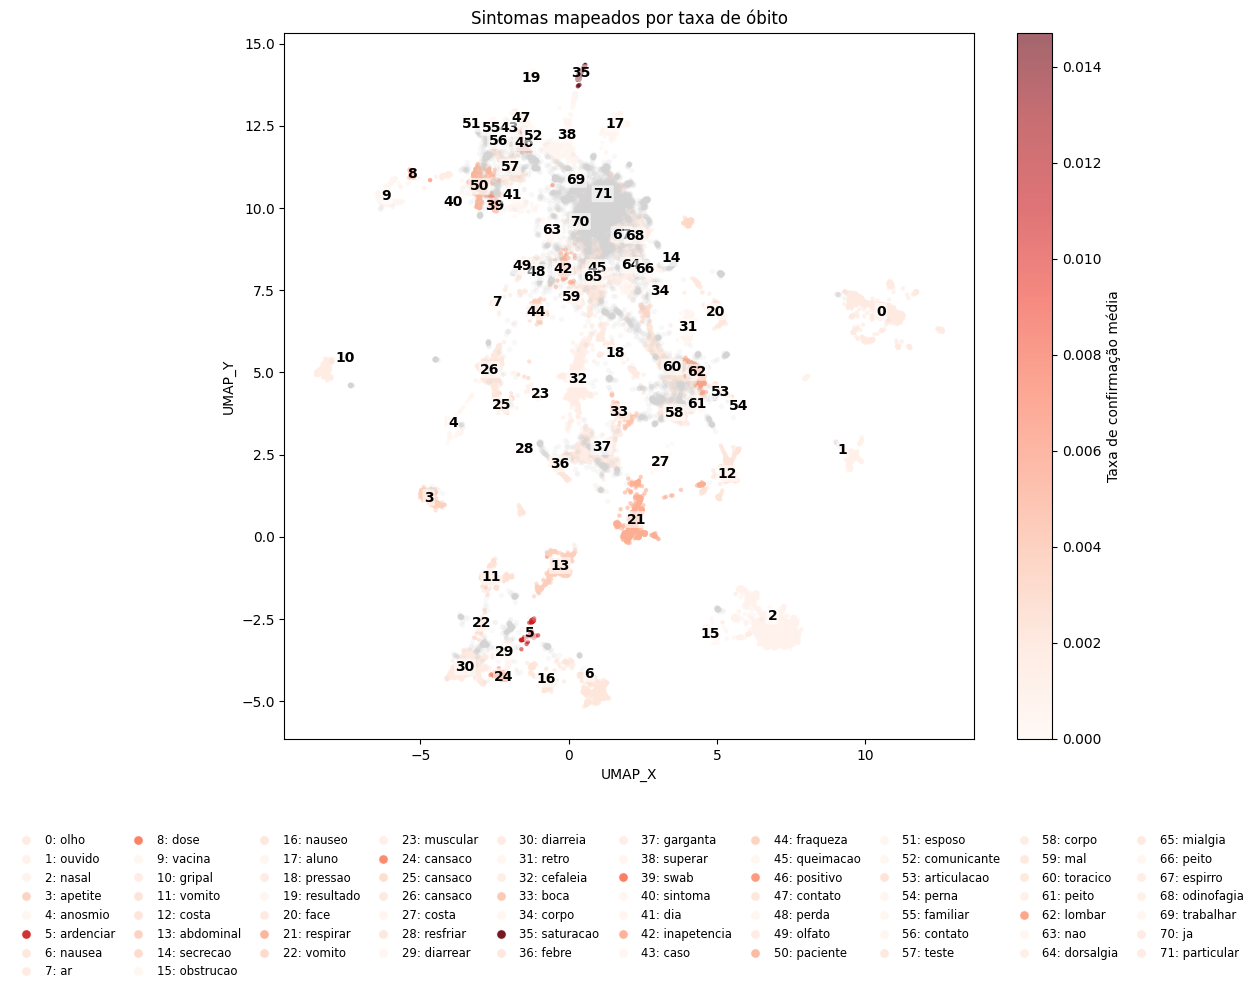

0.01 [label: 35.0] sintomas: 
[' sat 91%' ' sat 94%' ' sat 95' ' sat menor 95%']



0.01 [label: 35.0] sintomas: 
[' sat 91%' ' sat 94%' ' sat 95' ' sat menor 95%']



0.01 [label: 35.0] sintomas: 
[' sat 91%' ' sat 94%' ' sat 95' ' sat menor 95%']



0.01 [label: 35.0] sintomas: 
[' sat 91%' ' sat 94%' ' sat 95' ' sat menor 95%']



0.01 [label: 35.0] sintomas: 
[' sat 91%' ' sat 94%' ' sat 95' ' sat menor 95%']





In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import Normalize

plot_df = pd.DataFrame(data2d, columns=['UMAP_X', 'UMAP_Y'])
plot_df['cluster_label'] = clusterer.labels_


cluster_death_map = {label:(label2death[label][0]/label2death[label][1]) for label in unique_labels if label!=-1}
plot_df['death_rate'] = plot_df['cluster_label'].map(cluster_death_map).fillna(0.0)

fig, ax = plt.subplots(figsize=(12, 10))
vmin = plot_df['death_rate'].min()
vmax = plot_df['death_rate'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('Reds')

mask = plot_df['cluster_label'] != -1
sc = ax.scatter(
    plot_df.loc[mask, 'UMAP_X'],
    plot_df.loc[mask, 'UMAP_Y'],
    c=plot_df.loc[mask, 'death_rate'],
    cmap=cmap,
    norm=norm,
    s=10,
    alpha=0.6,
    linewidths=0,
)

# Se quiser mostrar ruído (-1) em cinza:
if (plot_df['cluster_label'] == -1).any():
    noise_mask = plot_df['cluster_label'] == -1
    ax.scatter(
        plot_df.loc[noise_mask, 'UMAP_X'],
        plot_df.loc[noise_mask, 'UMAP_Y'],
        color='lightgray',
        s=8,
        alpha=0.1,
        label='-1 (noise)'
    )

# Barra de cores (continua como no código 2)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Taxa de confirmação média')

# --- calcula centros por cluster para numerar ---
centers = (
    plot_df[plot_df['cluster_label'] != -1]
    .groupby('cluster_label')[['UMAP_X', 'UMAP_Y']]
    .mean()
)

# Para a legenda organizada: criamos uma entrada por cluster usando a cor
legend_handles = []
legend_labels = []

unique_labels = centers.index.to_numpy()  # labels distintos (sem -1)

for lab in unique_labels:
    # cor representativa do cluster = cor do colormap aplicada à taxa média (se existir)
    rate = float(cluster_death_map.get(lab, 0.0))
    color = cmap(norm(rate))

    # top term (tenta obter como no código 1)
    try:
        top_term = label2topterms[lab][0][0]
    except Exception:
        top_term = ""

    label_text = f"{lab}: {top_term}"
    # cria handle para a legenda (pequeno marcador circular)
    handle = Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                    markersize=6, alpha=0.9)
    legend_handles.append(handle)
    legend_labels.append(label_text)

    # coloca o número do cluster no centro (texto)
    cx, cy = centers.loc[lab, ['UMAP_X', 'UMAP_Y']]
    ax.text(
        cx, cy, str(lab),
        fontsize=10,
        fontweight="bold",
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.6)
    )

# --- legenda embaixo, centralizada, com colunas como no código 1 ---
ncol = 10  # ajuste conforme número de clusters / estética
ax.legend(
    legend_handles,
    legend_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=ncol,
    fontsize="small",
    frameon=False,
    markerscale=1.2,
    handletextpad=0.6,
    columnspacing=1.0
)

ax.set_title('Sintomas mapeados por taxa de óbito')
ax.set_xlabel('UMAP_X')
ax.set_ylabel('UMAP_Y')

# espaço para a legenda de baixo
fig.subplots_adjust(bottom=0.20)
plt.tight_layout()
plt.show()


## mostrando os sintomas que mais tem morte
for idx,row in plot_df[['cluster_label','death_rate']].sort_values(by='death_rate',ascending=False).head(5).iterrows():
    label = row['cluster_label']
    death_rate = row['death_rate']
    if label==-1:
        continue
    
    sintomas_idx = np.where(clusterer.labels_ == label)[0] ## index dos sintomas
    sintomas_subset = np.unique([all_sintomas[i] for i in sintomas_idx])
    
    print(f"{death_rate:.2f} [label: {label}] sintomas: \n{sintomas_subset[:4]}\n\n\n")

In [39]:
## Clusters com maiores proporções de mortes
for i,(label,death) in enumerate(sorted(label2death.items(), key=lambda x: x[1][0]/x[1][1], reverse=True)):
    if i>5:
        break
    terms = [a[0] for a in label2topterms[label]]
    
    idx = np.where(clusterer.labels_ == label)[0]
    sintomas_subset = [all_sintomas[i] for i in idx]
    
    print(f"cluster: {label} [{terms}]. death: {death}: ")
    for sintoma in sintomas_subset[:5]:
        print(sintoma)
    print("\n\n")

cluster: 35 [['saturacao', 'queda', 'levar', 'baixo', 'artralgiar']]. death: (6, 408): 
saturação < 95%
saturação <95
saturação 94
saturação ov menor que 95%
sat. 78 - 80 % a



cluster: 5 [['ardenciar', 'ardencer', 'dificuldade', 'alteracao', 'queixa']]. death: (2, 185): 
infeccao urinaria
urina forte e doresnas costas
infecção de urina
  queimação urina
dor renal



cluster: 39 [['swab', 'coleta', 'realizar', 'coletar', 'fazer']]. death: (1, 143): 
paciente comparece com resulatdo de swab para covid-19
realizou também o swab
coletado swab
colhido swab rapido
trouxe swab positivo feito em labotarorio particular



cluster: 8 [['dose', 'tomar', 'ja', 'uso', 'astenia']]. death: (1, 146): 
astrazenica 1° dose 04
2 doses astrazeneca
contato com positivo para covid 1 dose astrazenica
5ºc) por 2 dias com melhora parcial apos uso de azitromicina por 3 dias
2021 e 2 dose 09



cluster: 24 [['cansaco', 'fadigo', 'diarreio', 'fadiga', 'diarrear']]. death: (3, 474): 
diarréia. cansanço
cansaço e

## Agente
Problemática:
- queremos poder perguntar coisas como:
    - o sintoma X está associado com uma alta taxa de mortalidade? (dado fornecido diretamente pelo RAG)
    - o sintoma X está associado com uma alta infecção de covid?
    - estou sentido X,Y e Z. O que você pode dizer sobre? E pra esse caso ele teria que fazer algumas consultas diferentes
    

PromptCaller atendente:
- analisa o problema/pergunta da pessoa e decide quais queries fazer
- solta de volta: uma lista de queries que seriam necessárias para responder o problema.

rag:
- recebe uma namedTuple de requisição de RAG e revolve o resultado da RAG

PromptCaller simplificador
- com base na pergunta inicial e nas respostas, ele aglomera e separa a informação importante, descartando o que é inútil
- no fim, solta um texto que pontua os pontos importantes do retrieval que satisfazem a pergunta

PromptCaller respondedor
- com base no que saiu do simplificador e da resposta inicial, ele dá uma resposta para a pergunta inicial


texto_usuario:str --(atendente)--> queries(list:namedTupleRagQuery) --(RAG)--> documentos:list[namedTupleDoc] --(simplificador)--> resumo:str --(respondedor)--> resposta_final:str

In [40]:
import requests
def create_llm_query(url:str,model_name:str='llama3'):
    url = f"{url}/api/generate"
    
    # Cabeçalhos da requisição
    headers = {
        "Content-Type": "application/json"
    }
    
    def llm_query(system_prompt:str,prompt:str):
        payload = {
            "model": model_name,
            "system":system_prompt,
            "prompt": prompt,
            "stream": False
        }
        response = requests.post(url, headers=headers, json=payload)
        
        if response.status_code == 200:
            response = response.json()
            return response['response']
        else:
            raise SystemError("Erro na requisição:", response.status_code, response.text)
    return llm_query



## Criando o llm query
url = 'https://f610365999c4.ngrok-free.app'
llm_query = create_llm_query(url)

## teste:
llm_query("Independentemente do prompt, responda 'não vou responder'", "Bom dia, como vai?")

'Não vou responder.'

In [106]:
from typing import Callable
agent_count = 0
class PromptCaller():
    def __init__(self,
                 raw_prompt:Callable,
                 system_prompt:str,
                 llm_query:Callable,
                 output_formatter:Callable,
                 verbose=False,
                 name=None):
        """
        raw_prompt é um lambda que gera o prompt com espaços {} que entram argumentos
        system_prompt é o prompt de diretriz dele
        llm_query é a função (system_prompt:str,prompt:str)->str que deixa ele fazer uma requisição pra llm 
        output_formatter é uma função que deixa ele formatar o texto cru e recuperar os dados de output.
            Ela é do tipo:
                func(llm_output:str)->request_retry:bool, returned_object:[Object|None]
                
                request_retry - indica que algo não estava bem formatado e ele vai pedir uma nova consulta pra llm
                returned_object - objeto que foi formatado. Pode ser None  caso a request_retry seja True
                
                A função de output_formatter também pode dar raises de erros e sempre será chamada dentro de um try catch que 
                irá registrar caso isso ocorra
                
                
        """
        self.raw_prompt = raw_prompt
        self.system_prompt = system_prompt
        self.llm_query = llm_query
        self.output_formatter = output_formatter
        self.verbose = verbose
        
        if name is None:
            self.name = f"Agent {agent_count}"
            agent_count+=1 
        else:
            self.name = name
    def display_infos(self,infos,include_name=False):
        if not isinstance(infos,list):
            infos = [infos]
        if self.verbose:
            print("\n"*4)
            if include_name: print(f"{self.name} ",'='*50)
            for info in infos:
                print("="*20,'\n')
                print(info)
                print('\n',"="*20)
    
    def call(self,*prompt_args:list[str],verbose=False):
        self.verbose=verbose
        prompt = self.raw_prompt(*prompt_args) ## cria o prompt com base nos argumentos que precisa
        self.display_infos(prompt,include_name=True) ## se o verbose estiver ativo, mostra o prompt
        
        tentativa = 0
        output = None
        error = False
        while True:
            tentativa+=1
            try:
                ## chama a llm
                raw_llm_output = self.llm_query(self.system_prompt,prompt)
                self.display_infos(raw_llm_output)
                retry,output = self.output_formatter(raw_llm_output)
                if not retry: ## se o formatter não pedir retry, só sai do ciclo
                    break
            except Exception as exception:
                error_str = f"{self.name}, falha na {tentativa}° tentativa. Erro: \n{exception}"
                self.display_infos(error_str)
                break
        return error,output,tentativa ## retorna: se deu erro, qual foi o output formatado, quantas tentativas foram necessárias

#### Entendedor

In [107]:
import re
import json
import ast
from typing import Tuple, Optional, Dict, Any

ALLOWED_QUERY_TYPES = {"MORT", "INFEC"}

def extract_last_dollars_block(text: str) -> Optional[str]:
    """
    Retorna o conteúdo do último $$...$$ encontrado em `text`, sem os delimitadores.
    Se não encontrar, retorna None.
    """
    matches = re.findall(r'\$\$(.*?)\$\$', text, flags=re.DOTALL)
    if not matches:
        return None
    return matches[-1].strip()

def try_parse_json_fallback(s: str) -> Optional[Dict[str, Any]]:
    """
    Primeiro tenta json.loads. Se falhar, tenta ast.literal_eval como fallback (mais permissivo).
    Retorna dict ou None se não conseguir.
    """
    try:
        parsed = json.loads(s)
        if isinstance(parsed, dict):
            return parsed
        # se json válido mas não é objeto, consideramos inválido
        return None
    except Exception:
        # fallback: ast.literal_eval (aceita formato similar a dict Python)
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, dict):
                return parsed
            return None
        except Exception:
            return None

def normalize_query_obj(q_obj):
    """
    Normaliza diferentes formatos de especificação de queries:
    - Se q_obj for dict com chaves de nome de query -> valor dict
    - Se q_obj for uma lista de dicts -> retorna mapping name->obj se for do tipo [{"query1": {...}}, {...}]
      ou converte lista de objetos anônimos para {"query_1": obj, ...}
    Retorna dict nome->obj ou None se não for possível.
    """
    if isinstance(q_obj, dict):
        return q_obj  # já no formato esperado
    if isinstance(q_obj, list):
        out = {}
        anonymous_counter = 1
        for item in q_obj:
            if isinstance(item, dict):
                if len(item) == 1:
                    # formato ["query1": {...}]
                    key = next(iter(item.keys()))
                    out[key] = item[key]
                else:
                    # objeto com os campos diretamente -> atribui um nome gerado
                    out[f"query_{anonymous_counter}"] = item
                    anonymous_counter += 1
            else:
                # item inválido dentro da lista
                return None
        return out
    return None

def validate_schema(parsed: Dict[str, Any]) -> Tuple[bool, Optional[Dict[str, Any]]]:
    """
    Valida o schema exigido. Retorna (is_malformed, normalized_dict_or_None).
    Normaliza queries para um dict {query_name: {objetivo, tipo, parâmetros}}.
    """
    if not isinstance(parsed, dict):
        return True, None

    # Verifica campos top-level
    if "analise" not in parsed or "queries" not in parsed:
        return True, None

    if not isinstance(parsed["analise"], str):
        return True, None

    # Normaliza queries para dicionário
    norm_queries = normalize_query_obj(parsed["queries"])
    if norm_queries is None or len(norm_queries) == 0:
        return True, None

    # valida cada query
    for qname, qval in norm_queries.items():
        if not isinstance(qval, dict):
            return True, None
        # campos obrigatórios dentro da query
        for required in ("objetivo", "tipo", "parâmetros"):
            if required not in qval:
                return True, None
        # tipo deve ser MORT ou INFEC (case-insensitive aceito, mas validamos uppercase)
        tipo_val = qval["tipo"]
        if not isinstance(tipo_val, str):
            return True, None
        if tipo_val.upper() not in ALLOWED_QUERY_TYPES:
            return True, None
        # transforma tipo para uppercase padronizado
        qval["tipo"] = tipo_val.upper()
        # objetivo e parâmetros devem ser strings
        if not isinstance(qval["objetivo"], str) or not isinstance(qval["parâmetros"], str):
            return True, None

    # Se chegou até aqui, está válido — retornamos o objeto normalizado
    normalized = {
        "analise": parsed["analise"].strip(),
        "queries": norm_queries
    }
    return False, normalized

def parse_and_validate_from_text_entendedor(text: str) -> Tuple[bool, Optional[Dict[str, Any]]]:
    """
    Função principal conforme solicitado:
    - Recebe `text` (string)
    - Captura conteúdo do ÚLTIMO $$...$$
    - Tenta parsear JSON / fallback
    - Valida esquema
    Retorna: (is_malformed, data_dict_or_None)
      - is_malformed == True -> algo deu errado (não foi possível parsear/validar)
      - se False -> data_dict_or_None contém o dicionário normalizado pronto para uso
    """
    # 1) captura bloco
    block = extract_last_dollars_block(text)
    if block is None:
        return True, None

    # 2) tenta parsear
    parsed = try_parse_json_fallback(block)
    if parsed is None:
        return True, None

    # 3) validar schema
    is_malformed, normalized = validate_schema(parsed)
    if is_malformed:
        return True, None

    return False, normalized



# --------------------------
# Exemplo rápido de uso:
if __name__ == "__main__":
    exemplo = '''
    Some text before...
    $${
        "analise": "Paciente com sintomas X e Y, investigar associação com mortalidade",
        "queries": [
            {
                "objetivo": "ver taxa de mortalidade associada ao sintoma X",
                "tipo": "MORT",
                "parâmetros": "sintoma X mortalidade taxa"
            },
            {
                "objetivo": "ver prevalência do sintoma X em COVID",
                "tipo": "INFEC",
                "parâmetros": "sintoma X prevalência COVID"
            }
        ]
    }$$
    trailing text...
    '''
    malformed, output = parse_and_validate_from_text_entendedor(exemplo)
    print("malformed:", malformed)
    print("output:", json.dumps(output, ensure_ascii=False, indent=2))


malformed: False
output: {
  "analise": "Paciente com sintomas X e Y, investigar associação com mortalidade",
  "queries": {
    "query_1": {
      "objetivo": "ver taxa de mortalidade associada ao sintoma X",
      "tipo": "MORT",
      "parâmetros": "sintoma X mortalidade taxa"
    },
    "query_2": {
      "objetivo": "ver prevalência do sintoma X em COVID",
      "tipo": "INFEC",
      "parâmetros": "sintoma X prevalência COVID"
    }
  }
}


In [108]:
## Agente Recepcionista
## esse aqui ele tem o papel de analisar a pergunta do usuário, extraindo as queries de outros agentes que precisam ser feitas
## para que a pergunta seja respondida

system_prompt_entendedor = """
@Contexto: você faz parte de um sistema maior de agentes e é responsável por analisar perguntas relacionadas a uma base de dados de síndrome gripal, retornando quais 
são as queries necessárias para solucionar o problema.

Os @TiposQuery de query disponíveis são:
- 'MORT': irá retornar dados sobre a mortalidade
- 'INFEC': irá retornar dados sobre a infeção

@Entendimento do Retrieval:
O retrieval funciona recebendo uma palavra-chave e buscando ela com diversos sintomas relacionados a doenças.
Ou seja, ele não irá funcionar caso sejam palavras que não são sintomas. Exemplos que não funcionam: "sintoma", "covid-19"

@Formato de output:
$${
    "analise": < análise geral do problema >,
    "queries": [
        "query1": {
            "objetivo": < objetivo de se fazer a query >,
            "tipo": <TiposQuery: MORT ou INFEC>,
            "parâmetros": < texto string a ser enviado para o Retrieval, considere usar palavra-chave >
        },
        "query2": {
            ...
        }
        ...
    ]
}$$
"""

raw_prompt_entendedor = lambda inp: f"""

@Input: {inp}

Tarefa: Com base no prompt de sistema, você possui o @Contexto, @TiposQuery e @Formato de output. A partir disso, siga os passos abaixo:
1 - leia atentamente o @Input do usuário, visando entender as informações mais relevantes a ele.
2 - Com base no @Input, lista uma série de queries que são necessárias para responder o problema de forma mais aprofundada. 
3 - Analise as queries geradas. Altere-as para possuirem: um objetivo, um tipo de consulta (@TiposQuery descrito no prompt de sistema) e 
a palavra-chave a ser enviada para o Retrieval.
4 - Extraia quais são os sintomas que o usuário deu enfoque no @Input e faça queries sobre eles segundo esse formato também.
5 - Analise o conjunto de queries julgando se: elas fazem sentido? são realmente necessárias para responder a questão? estão bem formatadas? Caso 
alguma delas não cumpra com esses requisitos, volte ao passo 3 fazendo as alterações necessárias ou incluindo novas queries.
6 - Analise novamente o conjunto de queries individualmente. Caso as queries não sejam palavras-chaves cruas de sintomas para o Retrieval. Ou seja,
caso não sigam o @Entendimento do Retrieval contido no prompt de sistema, volte ao passo 3.
7 - Gere a resposta final no '@Formato de output' descrito no prompt de sistema.
8 - analise a resposta final e corrija erros de formatação.
9 - mostre o a resposta final no '@Formato de output' corrigida e lembrando de colocar nor formato $$resposta final$$
"""

def output_formatter_entendedor(output_llm:str):
    return parse_and_validate_from_text_entendedor(output_llm) ## só chama a outra função que valida mesmo

entendedor = PromptCaller(raw_prompt_entendedor,system_prompt_entendedor,llm_query,output_formatter_entendedor,name="Agente entendedor")

In [111]:
## Teste
pergunta = "Quais são os principais sintomas da covid?"
resposta = entendedor.call(pergunta,verbose=True)
resposta






Agente entendedor  ==================================================



@Input: Quais são os principais sintomas da covid?

Tarefa: Com base no prompt de sistema, você possui o @Contexto, @TiposQuery e @Formato de output. A partir disso, siga os passos abaixo:
1 - leia atentamente o @Input do usuário, visando entender as informações mais relevantes a ele.
2 - Com base no @Input, lista uma série de queries que são necessárias para responder o problema de forma mais aprofundada. 
3 - Analise as queries geradas. Altere-as para possuirem: um objetivo, um tipo de consulta (@TiposQuery descrito no prompt de sistema) e 
a palavra-chave a ser enviada para o Retrieval.
4 - Extraia quais são os sintomas que o usuário deu enfoque no @Input e faça queries sobre eles segundo esse formato também.
5 - Analise o conjunto de queries julgando se: elas fazem sentido? são realmente necessárias para responder a questão? estão bem formatadas? Caso 
alguma delas não cumpra com esses requisitos, volte a

(False,
 {'analise': 'Ocorrência de sintomas da Covid',
  'queries': {'query1': {'objetivo': 'identificar sintomas da Covid',
    'tipo': 'INFEC',
    'parâmetros': 'Fever'},
   'query2': {'objetivo': 'identificar sintomas da Covid',
    'tipo': 'INFEC',
    'parâmetros': 'Cansaço'},
   'query3': {'objetivo': 'identificar sintomas da Covid',
    'tipo': 'INFEC',
    'parâmetros': 'Dor de cabeça'},
   'query4': {'objetivo': 'identificar sintomas da Covid',
    'tipo': 'INFEC',
    'parâmetros': 'Dificuldade para respirar'},
   'query5': {'objetivo': 'identificar sintomas da Covid',
    'tipo': 'INFEC',
    'parâmetros': 'Dores musculares'}}},
 1)

#### Retrieval

In [112]:
from collections import namedtuple
from enum import Enum

class QueryTypes(Enum):
    INFECCAO=1
    MORTALIDADE=2

RagQuery = namedtuple('RagQuery',['objetivo','tipo','parâmetros'])
def queries_from_json(json_obj:dict) -> dict[str,RagQuery]:
    return {query_name:RagQuery(query_info['objetivo'],
                       QueryTypes.INFECCAO if query_info['tipo']=='INFEC' else (QueryTypes.MORTALIDADE if query_info['tipo']=='MORT' else None),
                       query_info['parâmetros'])  for query_name, query_info in json_obj['queries'].items()}
        

queries_from_json(resposta[1])

{'query1': RagQuery(objetivo='identificar sintomas da Covid', tipo=<QueryTypes.INFECCAO: 1>, parâmetros='Fever'),
 'query2': RagQuery(objetivo='identificar sintomas da Covid', tipo=<QueryTypes.INFECCAO: 1>, parâmetros='Cansaço'),
 'query3': RagQuery(objetivo='identificar sintomas da Covid', tipo=<QueryTypes.INFECCAO: 1>, parâmetros='Dor de cabeça'),
 'query4': RagQuery(objetivo='identificar sintomas da Covid', tipo=<QueryTypes.INFECCAO: 1>, parâmetros='Dificuldade para respirar'),
 'query5': RagQuery(objetivo='identificar sintomas da Covid', tipo=<QueryTypes.INFECCAO: 1>, parâmetros='Dores musculares')}

In [46]:
import numpy as np
import faiss
faiss_cpu = faiss.IndexFlatL2(data.shape[1])
faiss_cpu.add(data)

In [113]:
def Retrieval(queries:dict[str,RagQuery],k=5):
    queries_result = {}
    for query_name,query in queries.items():  
        embedding = model.encode([query.parâmetros])
        d = mapper.transform(embedding)
        distances, indices = faiss_cpu.search(d, k)
        
        indices = indices[0]
        sintomas = [all_sintomas[i] for i in indices]
        clusters_labels = np.unique(clusterer.labels_[indices])
        cluster_keywords = []
        
        query_return = {} ## label: {keywords:[...],rate:.323}
        
        for label in clusters_labels:
            if label==-1:
                continue
            query_return[label] = {'keywords':[tt[0] for tt in label2topterms[label]]}
            
            result = None
            if query.tipo==QueryTypes.INFECCAO:
                count,total = label2confirmed[label]
                query_return[label].update({'confirmados com covid':count,'total com sintoma':total})
            
            elif query.tipo==QueryTypes.MORTALIDADE:
                count,total = label2death[label]
                query_return[label].update({'óbitos':count,'total com sintoma':total})
        
        queries_result[query_name] = (sintomas,query_return)
        
    return queries_result

In [114]:
queries = queries_from_json(resposta[1])
queries_result = Retrieval(queries)
queries_result

{'query1': (['covid porém febre persiste',
   ' febre',
   'febre .',
   'febre hj',
   'febre '],
  {np.int64(36): {'keywords': ['febre', 'febril', 'sensacao', 'negar', 'dia'],
    'confirmados com covid': 56537,
    'total com sintoma': 213820}}),
 'query2': (['kibe lanche',
   'cançaco ',
   'buain;',
   'garganda incomanndo',
   'cheio'],
  {np.int64(71): {'keywords': ['particular',
     'internacao',
     'edema',
     'levar',
     'pa'],
    'confirmados com covid': 1493,
    'total com sintoma': 6525}}),
 'query3': (['cabeça ruim',
   'mialgia na testa.',
   '(dor de cabeça)',
   'incomodo na cabeça',
   'tontura e formigamento na cabeça'],
  {}),
 'query4': (['dificuldade p respiras',
   'peso ao respirar',
   'dificulldade para respirar',
   'peso no peito ar respirar',
   'incomodo ao respirar'],
  {np.int64(21): {'keywords': ['respirar',
     'respiratorio',
     'desconforto',
     'dificuldade',
     'pulmao'],
    'confirmados com covid': 696,
    'total com sintoma': 32

### Simplificador

In [115]:
def queries_results2txt(queries:dict[str,RagQuery],queries_result:dict):
    text = ""
    for query_name,query in queries.items():
        text += f"""Nome da query: {query_name}\n"""
        text += f"""Objetivo: {query.objetivo}\n"""
        text += f"""Tipo: {'INFECCAO' if query.tipo==QueryTypes.INFECCAO else ('MORTALIDADE' if query.tipo==QueryTypes.MORTALIDADE else "None")}\n"""
        text += f"""Palavras-chave: {query.parâmetros}\n"""
        text += f"""Resultados:\n"""
        sintomas, query_return = queries_result[query_name]
        text += f"    Sintomas associados: {sintomas}\n"
        text += f"    Informações dos clusters: \n"
        for cluster_label,info in query_return.items():
            text += f"        Cluster label: {int(cluster_label)}\n"
            text += f"        Info: {info}\n\n"
        text += '\n\n'
    return text
print(queries_results2txt(queries,queries_result))

Nome da query: query1
Objetivo: identificar sintomas da Covid
Tipo: INFECCAO
Palavras-chave: Fever
Resultados:
    Sintomas associados: ['covid porém febre persiste', ' febre', 'febre .', 'febre hj', 'febre ']
    Informações dos clusters: 
        Cluster label: 36
        Info: {'keywords': ['febre', 'febril', 'sensacao', 'negar', 'dia'], 'confirmados com covid': 56537, 'total com sintoma': 213820}



Nome da query: query2
Objetivo: identificar sintomas da Covid
Tipo: INFECCAO
Palavras-chave: Cansaço
Resultados:
    Sintomas associados: ['kibe lanche', 'cançaco ', 'buain;', 'garganda incomanndo', 'cheio']
    Informações dos clusters: 
        Cluster label: 71
        Info: {'keywords': ['particular', 'internacao', 'edema', 'levar', 'pa'], 'confirmados com covid': 1493, 'total com sintoma': 6525}



Nome da query: query3
Objetivo: identificar sintomas da Covid
Tipo: INFECCAO
Palavras-chave: Dor de cabeça
Resultados:
    Sintomas associados: ['cabeça ruim', 'mialgia na testa.', '(dor

In [118]:
## Agente Simplificador
##  esse tem o papel de reunir as informações anteriores e organizar para passar para frente

system_prompt_simplificador = """
@Contexto: você faz parte de um sistema maior de agentes e é responsável por analisar a informação vinda de outros agentes e 
organizar essa informação e enriquecer ela, deixando ela de forma mais limpa possível.

Os @TiposQuery de query disponíveis são:
- 'MORT': irá retornar dados sobre a mortalidade
- 'INFEC': irá retornar dados sobre a infeção

@Entendimento do Retrieval:
O retrieval funciona recebendo uma palavra-chave e buscando ela com diversos sintomas relacionados a doenças.
Ou seja, ele não irá funcionar caso sejam palavras que não são sintomas. Exemplos que não funcionam: "sintoma", "covid-19"

@Formato de output:
$$
Informações importantes retiradas:
- informação 1: com base na query ... tantas pessoas que tiveram esse sintoma testaram positivo.
- informação 2: ...
- informação 3: ...
$$
"""

raw_prompt_simplificador = lambda inp,infos: f"""

@Input: {inp}

@Informações retrieval: {infos}


Tarefa: Com base no prompt de sistema, você possui o @Contexto, @TiposQuery e @Formato de output. A partir disso, siga os passos abaixo:
1 - leia atentamente o @Input do usuário, visando entender as informações mais relevantes a ele.
2 - leia atentamente as informações retiradas do retrieval, elas estão organizadas em perguntas feitas anteriormente, bem como objetivo e resultados da query.
3 - faça uma segunda análise sobre os dados, dando preferência para aqueles que são relevantes para responder o @Input do usuário.
4 - Organize a informação em tópicos, como é mostrado no @Formato de output. Não é necessário seguir estritamente o @Formato de output, mas desde que ele
esteja organizado.
5 - revise a informação e inclua novos insights que podem ser extraídos dos dados e que podem ser relevantes a responder a questão. Caso você julgue
que não há dados suficientes para responder a questão, você deve colocar na resposta final $$Sem dados$$
6 - você pode enriquecer as informações ao relacionar trechos de palavras chaves ou os sintomas principais que apareceram em clusters.
7 - faça associações com os objetivos das queries com as respostas que constam agora. Por exemplo 'tópico 1: objetivo: ... resposta: ...'
8 - Caso existam dados relevantes, organize-os novamente em forma de tópicos e mostre-os de forma similar ao @Formato de output
9 - lembre-se de colocar a resposta final entre $$, conforme dado no @Formato de output
"""

## não precisa ficar verificando
def output_formatter_simplificador(output_llm:str):
    response = extract_last_dollars_block(output_llm)
    if response is None:
        return True,None
    else:
        return False,response

simplificador = PromptCaller(raw_prompt_simplificador,system_prompt_simplificador,llm_query,output_formatter_simplificador,name="Agente simplificador")

In [120]:
queries_txt = queries_results2txt(queries,queries_result)
simplificado = simplificador.call(pergunta,queries_txt,verbose=True)
print(simplificado[1])






Agente simplificador  ==================================================



@Input: Quais são os principais sintomas da covid?

@Informações retrieval: Nome da query: query1
Objetivo: identificar sintomas da Covid
Tipo: INFECCAO
Palavras-chave: Fever
Resultados:
    Sintomas associados: ['covid porém febre persiste', ' febre', 'febre .', 'febre hj', 'febre ']
    Informações dos clusters: 
        Cluster label: 36
        Info: {'keywords': ['febre', 'febril', 'sensacao', 'negar', 'dia'], 'confirmados com covid': 56537, 'total com sintoma': 213820}



Nome da query: query2
Objetivo: identificar sintomas da Covid
Tipo: INFECCAO
Palavras-chave: Cansaço
Resultados:
    Sintomas associados: ['kibe lanche', 'cançaco ', 'buain;', 'garganda incomanndo', 'cheio']
    Informações dos clusters: 
        Cluster label: 71
        Info: {'keywords': ['particular', 'internacao', 'edema', 'levar', 'pa'], 'confirmados com covid': 1493, 'total com sintoma': 6525}



Nome da query: query3
Objetiv

### Respondedor

In [128]:
## Agente Respondedor
##  esse tem o papel de pegar a pergunta inicial e as informações 

system_prompt_respondedor = """
@Contexto: você faz parte de um sistema maior de agentes e é responsável por responder a pergunta do usuário conforme as informações dos outros agentes. Lembre-se 
que sua função é fornecer uma resposta a um usuário leigo, então é necessário ser claro, explicar os sintomas, os dados e responder sua pergunta de forma clara e precisa.

@Formato de output:
$$
<sua resposta>
$$
"""

raw_prompt_respondedor = lambda inp,infos: f"""

@Input: {inp}

@Informações dos agentes: 
{infos}


Tarefa: Com base no prompt de sistema, você possui o @Contexto e @Formato de output. A partir disso, siga os passos abaixo:
1 - leia atentamente o @Input do usuário, visando entender as informações mais relevantes a ele.
2 - leia atentamente as @Informações dos agentes, elas estão organizadas em perguntas feitas anteriormente, bem como objetivo e resultados das queries.
3 - com base nas @Informações dos agentes, resposta a pergunta @Input
4 - revise a própria resposta, tendo certeza que os dados dela são confiáveis e que todos estão presentes nas @Informações dos agentes. Caso haja algum
dado que não possa ser confirmado, volte a etapa 3 e revise o texto.
5 - faça a construção da resposta final, lembrando que ela precisa RESPONDER a @Input e não somente fornecer os dados.
6 - revise para que a resposta final de fato responda as perguntas do usuário e faça os apontamentos necessários para quanto há ou não há dados sobre.
7 - mostre a resposta final lembrando de colocar a resposta final no formato $$respostafinal$$, conforme dado no @Formato de output.
"""

## não precisa ficar verificando
def output_formatter_respondedor(output_llm:str):
    response = extract_last_dollars_block(output_llm)
    if response is None:
        return True,None
    else:
        return False,response

respondedor = PromptCaller(raw_prompt_respondedor,system_prompt_respondedor,llm_query,output_formatter_respondedor,name="Agente respondedor")

In [129]:
resposta_final = respondedor.call(pergunta,simplificado)
print(resposta_final[1])

Perda de apetite é um sintoma que pode ser causado pela Covid-19. Embora não seja um dos principais sintomas listados nos dados disponíveis (Fever, Cansaço, Dificuldade para respirar e Dores musculares), a perda de apetite pode ser um sinal de que o corpo está lutando contra a doença. É importante notar que os sintomas da Covid-19 podem variar dependendo do indivíduo afetado e a perda de apetite não é um sintoma exclusivo da doença, mas sim uma possibilidade entre muitas outras. Portanto, se você está experimentando perda de apetite, é importante consultar um médico para avaliar seus sintomas e descartar outras possibilidades de doenças.''


### Pipeline

In [130]:
def pipeline(pergunta:str,verbose=False):
    ## Teste
    error,resposta,tries = entendedor.call(pergunta,verbose=verbose)
    if error:
        raise Exception("Error no entendedor")
    
    queries = queries_from_json(resposta)
    queries_result = Retrieval(queries)
    
    queries_txt = queries_results2txt(queries,queries_result)
    error,simplificado,tries = simplificador.call(pergunta,queries_txt,verbose=verbose)
    if error:
        raise Exception("Error no simplificador")
    
    error,resposta_final,tries = respondedor.call(pergunta,simplificado,verbose=verbose)
    if error:
        raise Exception("Error ao fazer a resposta final.")
    return resposta_final

In [132]:
pergunta = "Perda de sangue é um sintoma da covid-19?"
resposta_final = pipeline(pergunta,verbose=True)
print("\n\n\n\n\n\n\n\n")
print(resposta_final)






Agente entendedor  ==================================================



@Input: Perda de sangue é um sintoma da covid-19?

Tarefa: Com base no prompt de sistema, você possui o @Contexto, @TiposQuery e @Formato de output. A partir disso, siga os passos abaixo:
1 - leia atentamente o @Input do usuário, visando entender as informações mais relevantes a ele.
2 - Com base no @Input, lista uma série de queries que são necessárias para responder o problema de forma mais aprofundada. 
3 - Analise as queries geradas. Altere-as para possuirem: um objetivo, um tipo de consulta (@TiposQuery descrito no prompt de sistema) e 
a palavra-chave a ser enviada para o Retrieval.
4 - Extraia quais são os sintomas que o usuário deu enfoque no @Input e faça queries sobre eles segundo esse formato também.
5 - Analise o conjunto de queries julgando se: elas fazem sentido? são realmente necessárias para responder a questão? estão bem formatadas? Caso 
alguma delas não cumpra com esses requisitos, volte ao